In [ ]:
from IPython.display import HTML, clear_output
import sys
import boto3
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta, date
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import networkx as nx
from torch_geometric.data import Data, DataLoader, Dataset

wh = Waveform_Helper()

athena = Athena_Query()

In [ ]:
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

# Load and preprocess data
# Merge dataframes
merged_df = hrv.merge(vital, on='patientid', how='inner')
merged_df = merged_df.merge(lab, on='patientid', how='inner')
merged_df = merged_df.merge(gcs, on='patientid', how='inner')
merged_df = merged_df.merge(age, on='patientid', how='inner')
metrics = ['SDNN (ms)', 'SDANN (ms)', 'MeanRR (ms)', 'RMSSD (ms)', 'pNN50 (%)', 'P_VLF (%)','P_LF (%)','P_HF (%)','HF/LF', 'REC (%)','DET (%)','LAM (%)','SD1', 'SD2', 'alpha1' ,'alpha2',
          'HR (mean)','Diastolic BP (mean)','Systolic BP (mean)','ABP Mean (mean)','SpO2 (mean)','HR (slope)','Diastolic BP (slope)','Systolic BP (slope)','ABP Mean (slope)','SpO2 (slope)','HR_std','Diastolic BP_std','Systolic BP_std','ABP Mean_std','SpO2_std',
          'so2','po2','pco2','hemoglobin','carboxyhemoglobin', 'methemoglobin','chloride','calcium','anion_gap','temperature','potassium','sodium','lactate','glucose',
          'GCS(eyes)_12hr','GCS(motor)_12hr','GCS(verbal)_12hr','GCS_final',
          'age_on_adm','gender']

# Calculate correlation matrix
correlation_matrix = merged_df[metrics].corr()
plt.figure(figsize=(20, 20))
# Visualize correlation matrix as heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)


group_boundaries = [0, 16, 31, 45, 49, 51]

# Add group separation lines
for boundary in group_boundaries:
    plt.axhline(y=boundary, color='r', linewidth=2)
    plt.axvline(x=boundary, color='r', linewidth=2)
    
    
plt.savefig(f'heatmap.png', dpi=100, bbox_inches='tight')
plt.title("Feature Correlation Heatmap")
plt.show()

***New method***

In [ ]:
G = nx.Graph()

metrics = ['SDNN (ms)', 'SDANN (ms)', 'MeanRR (ms)', 'RMSSD (ms)', 'pNN50 (%)', 'P_VLF (%)','P_LF (%)','P_HF (%)','HF/LF', 'REC (%)','DET (%)','LAM (%)','SD1', 'SD2', 'alpha1' ,'alpha2',
          'HR (mean)','Diastolic BP (mean)','Systolic BP (mean)','ABP Mean (mean)','SpO2 (mean)','HR (slope)','Diastolic BP (slope)','Systolic BP (slope)','ABP Mean (slope)','SpO2 (slope)','HR_std','Diastolic BP_std','Systolic BP_std','ABP Mean_std','SpO2_std',
          'so2','po2','pco2','hemoglobin','carboxyhemoglobin', 'methemoglobin','chloride','calcium','anion_gap','temperature','potassium','sodium','lactate','glucose',
          'GCS(eyes)_12hr','GCS(motor)_12hr','GCS(verbal)_12hr','GCS_final',
          'age_on_adm','gender']
# Define the subsets and their colors
set_colors = {'hrv': 'blue', 'vital': 'green', 'lab': 'red', 'gcs': 'gray', 'age': 'yellow'}

# Initialize a dictionary to store community assignments for each subset
community_assignments = {subset: {} for subset in set_colors.keys()}

# Add nodes (features) to the graph and assign colors
for feature in merged_[metrics]:
    subset = feature_sets.loc[feature.strip()]['Set']
    G.add_node(feature, color=set_colors[subset])

    

correlation_matrix = merged_[metrics].corr()
# Add edges (significant correlations) with a weight of 1
threshold = 0.5  # Adjust this threshold as needed
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j], weight=1)

# Create a mapping from node names to integers
node_to_index = {node: i for i, node in enumerate(G.nodes)}

# Map the nodes to integers in the edge list
edge_index = torch.tensor([(node_to_index[u], node_to_index[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()


# Convert the adjacency matrix to a dense PyTorch tensor
adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix = torch.tensor(adjacency_matrix.todense(), dtype=torch.float)

# Print adjacency matrix and edge indices
print("Edge Index Shape:", edge_index.shape)
print("Edge Index Content:", edge_index)
print("Adjacency Matrix:")
print(adjacency_matrix)
print("Edge Indices:")
print(edge_index)


In [ ]:
import matplotlib.pyplot as plt

# Compute the layout positions of the nodes using a force-directed layout algorithm
pos = nx.spring_layout(G, seed=42)  # You can choose different layout algorithms as well

# Define node colors based on subsets
node_colors = [node[1]['color'] for node in G.nodes(data=True)]
plt.figure(figsize=(20, 20))
# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, cmap=plt.cm.Blues)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw node labels if needed
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', font_weight='bold')
plt.savefig("gnn_grapg.png") 
plt.axis('off')
plt.show()


***AUTOENCODER METHOD***

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch_geometric.data import Data

class CustomDataset(Dataset):
    def __init__(self, adjacency_matrix, edge_index):
        self.graph_data = Data(x=torch.tensor(adjacency_matrix, dtype=torch.float),
                               edge_index=edge_index)

    def __len__(self):
        return 1  # This dataset contains only one graph

    def __getitem__(self, idx):
        return self.graph_data

# Create a DataLoader for your dataset
dataset = CustomDataset(adjacency_matrix, edge_index)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [23]:
def custom_collate(batch):
    # `batch` is a list of Data objects
    return torch_geometric.data.Batch.from_data_list(batch)

# Create a DataLoader with the custom collate function
train_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)

In [24]:
#Define the GCN model
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GraphAutoencoder(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(GraphAutoencoder, self).__init__()
        self.encoder = GCNConv(num_features, hidden_dim)
        self.decoder = GCNConv(hidden_dim, num_features)

    def forward(self, x, edge_index):
        # Encoder
        x = self.encoder(x, edge_index)
        # Decoder
        x = self.decoder(x, edge_index)
        return x


In [ ]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch_geometric.nn import GCNConv
import networkx as nx

num_features = adjacency_matrix.shape[0]  # Number of nodes in the graph
hidden_dim = 64
model = GraphAutoencoder(num_features, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 1000  # Adjust the number of epochs as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphAutoencoder(num_features, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)  # Send the data to the appropriate device (CPU or GPU)
        output = model(data.x, data.edge_index)
        loss = torch.nn.functional.mse_loss(output, data.x)  # Mean Squared Error as the reconstruction loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch: {epoch + 1}, Loss: {average_loss}')

In [ ]:
# Assuming you have a graph G created using networkx

# Step 1: Compute node degrees
node_degrees = dict(G.degree())

# Step 2: Sort nodes based on degrees in descending order
sorted_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)

# Step 3: Get top 20 nodes
top_20_nodes = sorted_nodes[:20]

# Print or use the top 20 nodes as needed
print("Top 20 Nodes based on Degree:", top_20_nodes)


In [29]:
from node2vec import Node2Vec
from sklearn.decomposition import PCA

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Fit the model (generate node embeddings)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get the embeddings for all nodes
node_embeddings = model.wv

Computing transition probabilities:   0%|          | 0/51 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:00<00:00, 180.86it/s]


In [ ]:
# Reduce dimensionality with PCA
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(node_embeddings.vectors)

# Extract node names (replace with your node labels or IDs)
node_names = list(G.nodes())

# Create a scatter plot for visualization
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c='b', marker='o')

# Annotate nodes with their labels or IDs
for i, txt in enumerate(node_names):
    plt.annotate(txt, (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]))

plt.title('Node Embedding Visualization (2D)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

***After apply hyperparametwr tuning***

In [31]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

class GCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return 1  # This dataset contains only one graph

    def __getitem__(self, idx):
        return self.data

def train(model, data, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = criterion(output, data.x)  # Mean Squared Error as the reconstruction loss
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, criterion, device):
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
        loss = criterion(output, data.x)
    return loss.item()

# Define your hyperparameters grid to search
hidden_dims = [32, 64, 128, 256]
learning_rates = [0.001, 0.01, 0.1]
num_epochs = 1000
num_classes = 51

# Define your dataset and DataLoader here (assuming you have 'dataset' and 'train_loader')

best_loss = float('inf')
best_params = None

# Grid search for hyperparameter tuning
for hidden_dim in hidden_dims:
    for learning_rate in learning_rates:
        model = GCN(num_features, hidden_dim, num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()  # Mean Squared Error Loss

        for epoch in range(num_epochs):
            train_loss = train(model, data, optimizer, criterion, device)
            val_loss = evaluate(model, data, criterion, device)
            
            # Print training progress if needed
            # print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = {'hidden_dim': hidden_dim, 'learning_rate': learning_rate}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'hidden_dim': 256, 'learning_rate': 0.01}


In [32]:
# Define your GCN model with the best hyperparameters
best_hidden_dim = 256
best_learning_rate = 0.01

class GCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model, send it to the appropriate device, and set up the optimizer
model = GCN(num_features, best_hidden_dim, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)

# Train the model using your full dataset (data) and its edge indices (edge_index) for a certain number of epochs
num_epochs = 10000  # You can adjust the number of epochs based on your dataset and model complexity
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = torch.nn.functional.mse_loss(output, data.x)  # Mean Squared Error as the reconstruction loss
    loss.backward()
    optimizer.step()

# Get node embeddings after training
with torch.no_grad():
    model.eval()
    node_embeddings = model(data.x, data.edge_index)

# Assuming you want to select the top nodes based on L2 norm of embeddings
node_norms = torch.norm(node_embeddings, dim=1)
_, indices = torch.topk(node_norms, k=20, largest=True)
top_20_nodes = list(indices.cpu().numpy())

In [ ]:


# Calculate L2 norms for node embeddings
node_norms = torch.norm(node_embeddings, dim=1)


# Select top 20 features based on L2 norms
_, indices = torch.topk(node_norms, k=20, largest=True)
top_20_nodes = [i.item() for i in indices]

# Map the indices back to feature names based on your graph's node labels
feature_names = [list(G.nodes())[i] for i in top_20_nodes]

# Get top 20 scores for the selected features (nodes)
top_20_scores = [node_norms[i].item() for i in top_20_nodes]

In [ ]:
if 'GCS_FINAL' in feature_names:
    feature_names.remove('GCS_FINAL')
    top_20_scores = [score for feature, score in zip(feature_names, top_20_scores) if feature != 'GCS_FINAL']

# Plot the bar chart for the top 20 features and their scores
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(feature_names)), top_20_scores, align='center')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel('Importance Score')
plt.ylabel('Node Attributes')
plt.title('Top 20 important')
plt.gca().invert_yaxis()
plt.savefig(f'feature importance GCN top 20_new.png', dpi=100, bbox_inches='tight')# Invert the y-axis to show the most important feature at the top

plt.show()

In [ ]:


# Calculate L2 norms for node embeddings excluding GCS_final index
node_norms = torch.norm(node_embeddings, dim=1)

# Exclude GCS_final index from normalized_scores and feature_names
normalized_scores = [(score - node_norms.min()) / (node_norms.max() - node_norms.min()) for i, score in enumerate(node_norms) if i != gcs_final_index]
feature_names = [list(G.nodes())[i] for i in range(len(node_norms)) if i != gcs_final_index]

# Create an array of angles for the radar chart
angles = np.linspace(0, 2 * np.pi, len(feature_names), endpoint=False).tolist()

# Duplicate the first angle and append it to match the extra normalized score
angles += angles[:1]

# Create a figure and axis
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Fill the radar plot
ax.fill(angles, normalized_scores + [normalized_scores[0]], 'b', alpha=0.1)  # Append the first score to match the length

# Set the labels for each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feature_names)

# Set the y-labels and limit the y-axis to 0-1
ax.set_rlabel_position(0)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
plt.ylim(0, 1)
plt.title('Normalized Important Scores for All Features')
plt.savefig(f'feature_importance_GCN_radar_chart.png')
plt.show()

In [ ]:
# Sort features based on normalized scores in descending order
sorted_indices = sorted(range(len(normalized_scores)), key=lambda k: normalized_scores[k], reverse=True)

# Select top 20 features
top_20_indices = sorted_indices[:20]
top_20_feature_names = [feature_names[i] for i in top_20_indices]
top_20_normalized_scores = [normalized_scores[i] for i in top_20_indices]

# Create an array of angles for the radar chart
angles = np.linspace(0, 2 * np.pi, len(top_20_feature_names), endpoint=False).tolist()
angles += angles[:1]  # Duplicate the first angle to close the radar chart

# Create a figure and axis
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Fill the radar plot for top 20 features
ax.fill(angles, top_20_normalized_scores + [top_20_normalized_scores[0]], 'b', alpha=0.1)  

# Set the labels for each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(top_20_feature_names)

# Set the y-labels and limit the y-axis to 0-1
ax.set_rlabel_position(0)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
plt.ylim(0, 1)
plt.title('Normalized Important Scores for Top 20 Features')
plt.savefig(f'feature_importance_GCN_top_20_radar_chart.png')
plt.show()


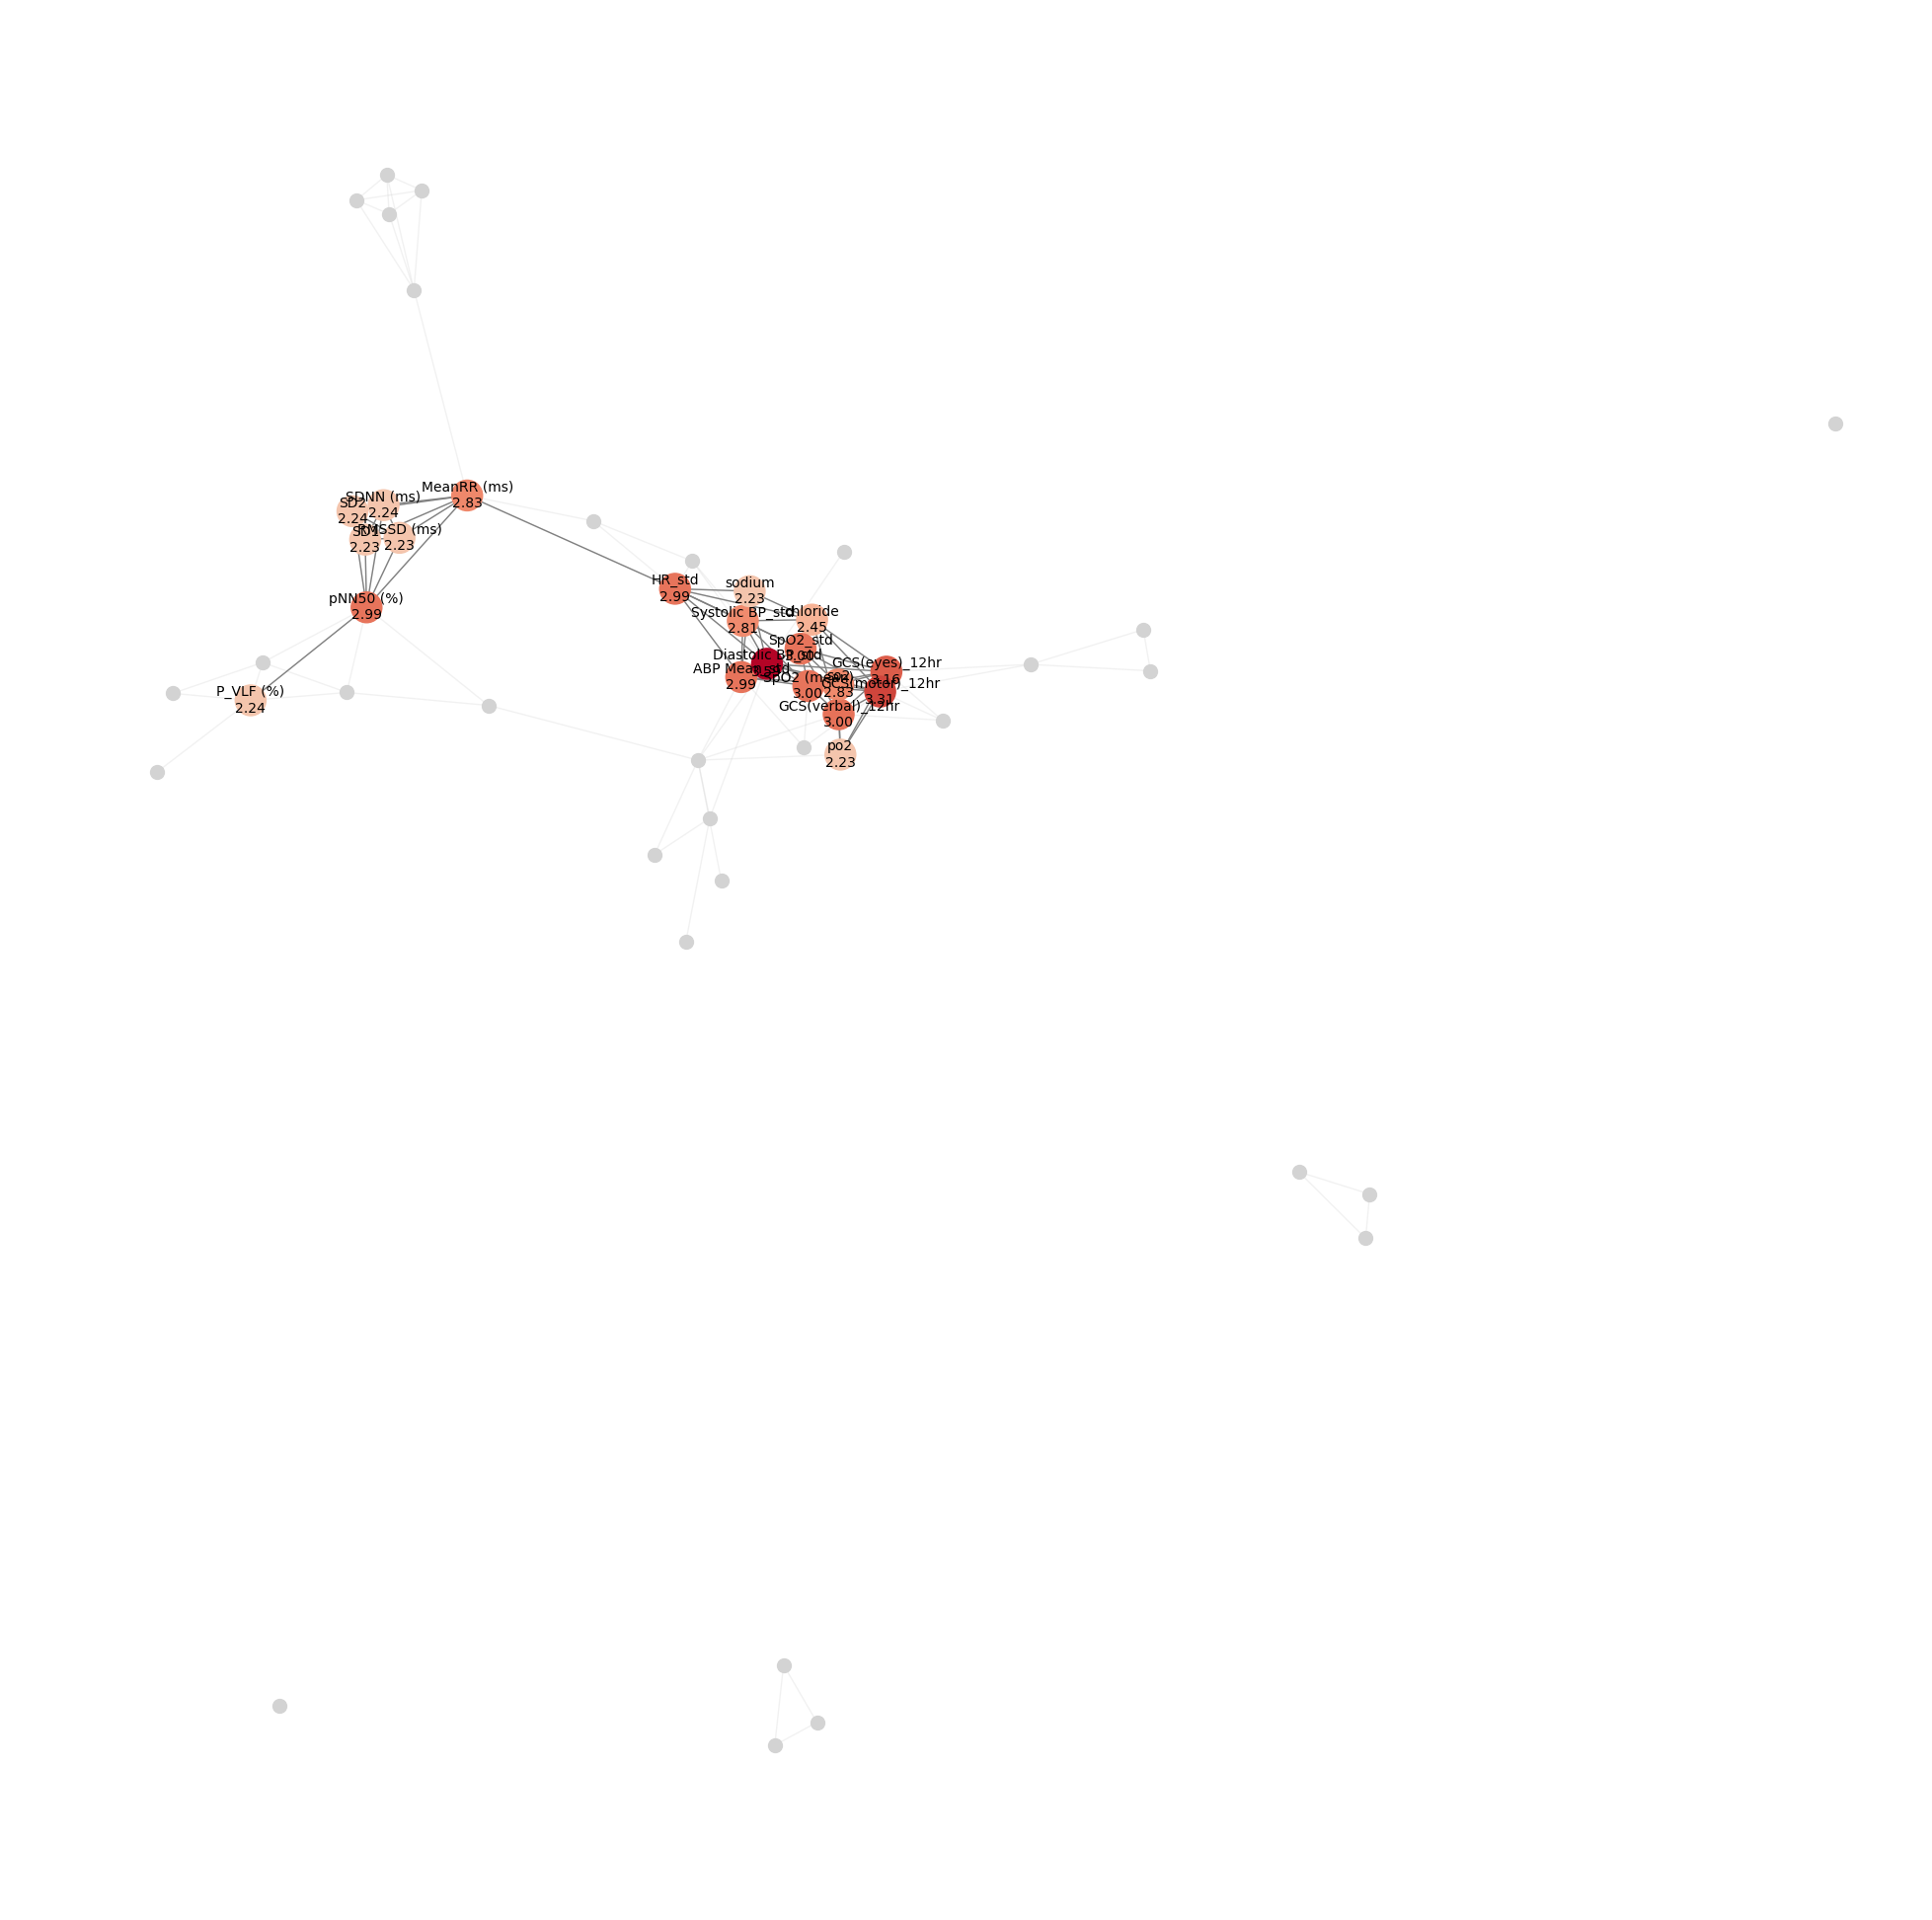

In [43]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Calculate importance scores for nodes in G_top_k
top_k_scores = [node_norms[i].item() for i in indices]

# Create a new graph containing only the top 20 nodes and their edges
top_k_nodes = [list(G.nodes())[i] for i in indices]
G_top_k = G.subgraph(top_k_nodes)

# Define a color map based on importance scores using the 'coolwarm' colormap
color_map = []
for node in G_top_k.nodes():
    if node in top_k_nodes:
        index = top_k_nodes.index(node)
        score = top_k_scores[index]
        # Map the scores to colors using the 'coolwarm' colormap
        color = plt.cm.coolwarm(score / max(top_k_scores))  # coolwarm colormap, normalized to the maximum score
        color_map.append(color)
    else:
        color_map.append('lightgrey')  # Color for nodes not in the top 20

# Draw the entire graph with all edges
plt.figure(figsize=(25, 25))
pos = nx.spring_layout(G, seed=42)

# Draw all nodes with labels and colors based on real importance scores
all_nodes = nx.draw_networkx_nodes(G, pos, node_color='lightgrey', node_size=100)
all_edges = nx.draw_networkx_edges(G, pos, edge_color='lightgrey', alpha=0.3)

# Draw top 20 nodes with labels and colors based on real importance scores
top_nodes = nx.draw_networkx_nodes(G_top_k, pos, node_color=color_map, node_size=500)
top_edges = nx.draw_networkx_edges(G_top_k, pos, edge_color='grey')

# Annotate top 20 nodes with their labels and scores
node_labels = {node: f"{node}\n{score:.2f}" for node, score in zip(top_k_nodes, top_k_scores)}
labels = nx.draw_networkx_labels(G_top_k, pos, labels=node_labels, font_size=10)

# Remove node labels and axis
plt.axis('off')
plt.savefig(f'top 20 GRAPH_new.png')
plt.show()

